# Factors that Affect Life Expectancy
Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

First, load the dataset.

Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

## Data Import and Cleaning
The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                    postgres_user, postgres_pw, postgres_host, 
                    postgres_port, postgres_db))

# Import the data
df = pd.read_sql_table(table_name, con=engine)

engine.dispose()
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
# what is the sum of NAN values
df.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [4]:
# noted white space in list above applying strip
df = df.rename(columns=lambda x: x.strip())

# what is the summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
BMI                                2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
HIV/AIDS                           2938 non-null

In [5]:
# dataframe statistics
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


## Filling missing values
Looking at the charts above the majority of the missing values are based on variables that are unique to each country. The variables will be filled by interpolate based on a groupby country. The missing life expectancy is for one country. As there is no camparable data within that country interpolate, the missing values will be filled based on the average world-wide life expectancy. The remaining missing values will be filled based on a standard interpolate on the entire data-set not just by country. 

In [6]:
# Interpolate based on country
df = df.groupby('Country').apply(
    lambda x: x.interpolate()).reset_index()

# Drop index as it is useless
df.drop(['index'], axis=1, inplace=True)

# check to see if all values are filled
df.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            192
percentage expenditure               0
Hepatitis B                        144
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                                0
Total expenditure                  210
Diphtheria                           0
HIV/AIDS                             0
GDP                                422
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

In [7]:
# Fill 10 missing life expectancy rows with the average in data
df['Life expectancy'].fillna(df['Life expectancy'].mean(), inplace=True)

# Fill remaining amounts based on life expectancy
df = df.groupby('Life expectancy').apply(
    lambda x: x.interpolate()).reset_index()

df.drop(['index'], axis=1, inplace=True)

# check to see if all values are filled
df.isna().sum()

Country                             0
Year                                0
Status                              0
Life expectancy                     0
Adult Mortality                    10
infant deaths                       0
Alcohol                            25
percentage expenditure              0
Hepatitis B                         8
Measles                             0
BMI                                 0
under-five deaths                   0
Polio                               0
Total expenditure                  28
Diphtheria                          0
HIV/AIDS                            0
GDP                                47
Population                         74
thinness  1-19 years                0
thinness 5-9 years                  0
Income composition of resources    18
Schooling                          18
dtype: int64

In [8]:
df = df.apply(
    lambda x: x.interpolate()).reset_index()

# check to see if all values are filled
df.isna().sum()

index                              0
Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
dtype: int64

In [9]:
# statistics of each variable
df.describe()

,index,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.00000,2938.000000,2938.000000
mean,1468.500000,2007.518720,69.224932,164.744554,30.303948,4.594915,738.251295,76.055026,2419.592240,38.156382,...,82.307692,5.919748,82.075221,1.742103,7259.909441,1.314308e+07,4.867682,4.90337,0.626507,11.958781
std,848.271871,4.613841,9.507640,124.226596,117.926501,3.998754,1987.914858,28.244927,11467.272489,20.059699,...,23.636677,2.473411,23.917022,5.077785,13876.828716,5.943391e+07,4.433064,4.52727,0.211961,3.387277
min,0.000000,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,...,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.10000,0.000000,0.000000
25%,734.250000,2004.000000,63.200000,74.000000,0.000000,0.990000,4.685343,66.000000,0.000000,19.200000,...,77.000000,4.260000,78.000000,0.100000,494.711459,2.941158e+05,1.600000,1.60000,0.491000,10.000000
50%,1468.500000,2008.000000,72.000000,144.000000,3.000000,3.775000,64.912906,89.000000,17.000000,43.000000,...,93.000000,5.720000,93.000000,0.100000,1856.139673,1.682964e+06,3.400000,3.40000,0.677000,12.300000
75%,2202.750000,2012.000000,75.600000,228.000000,22.000000,7.615000,441.534144,96.000000,360.250000,56.100000,...,97.000000,7.470000,97.000000,0.800000,5828.714590,7.864674e+06,7.200000,7.30000,0.781000,14.200000
max,2937.000000,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,...,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.60000,0.948000,20.700000


In [10]:
# List of all continuous variables
variables = ['Year', 'Life expectancy', 'Adult Mortality', 'infant deaths', 
            'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles',
            'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria',
            'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 
            'thinness 5-9 years', 'Income composition of resources', 'Schooling']

## Outliers
Each of the numeric variables will be plotted below and the outliers will be dealt with.

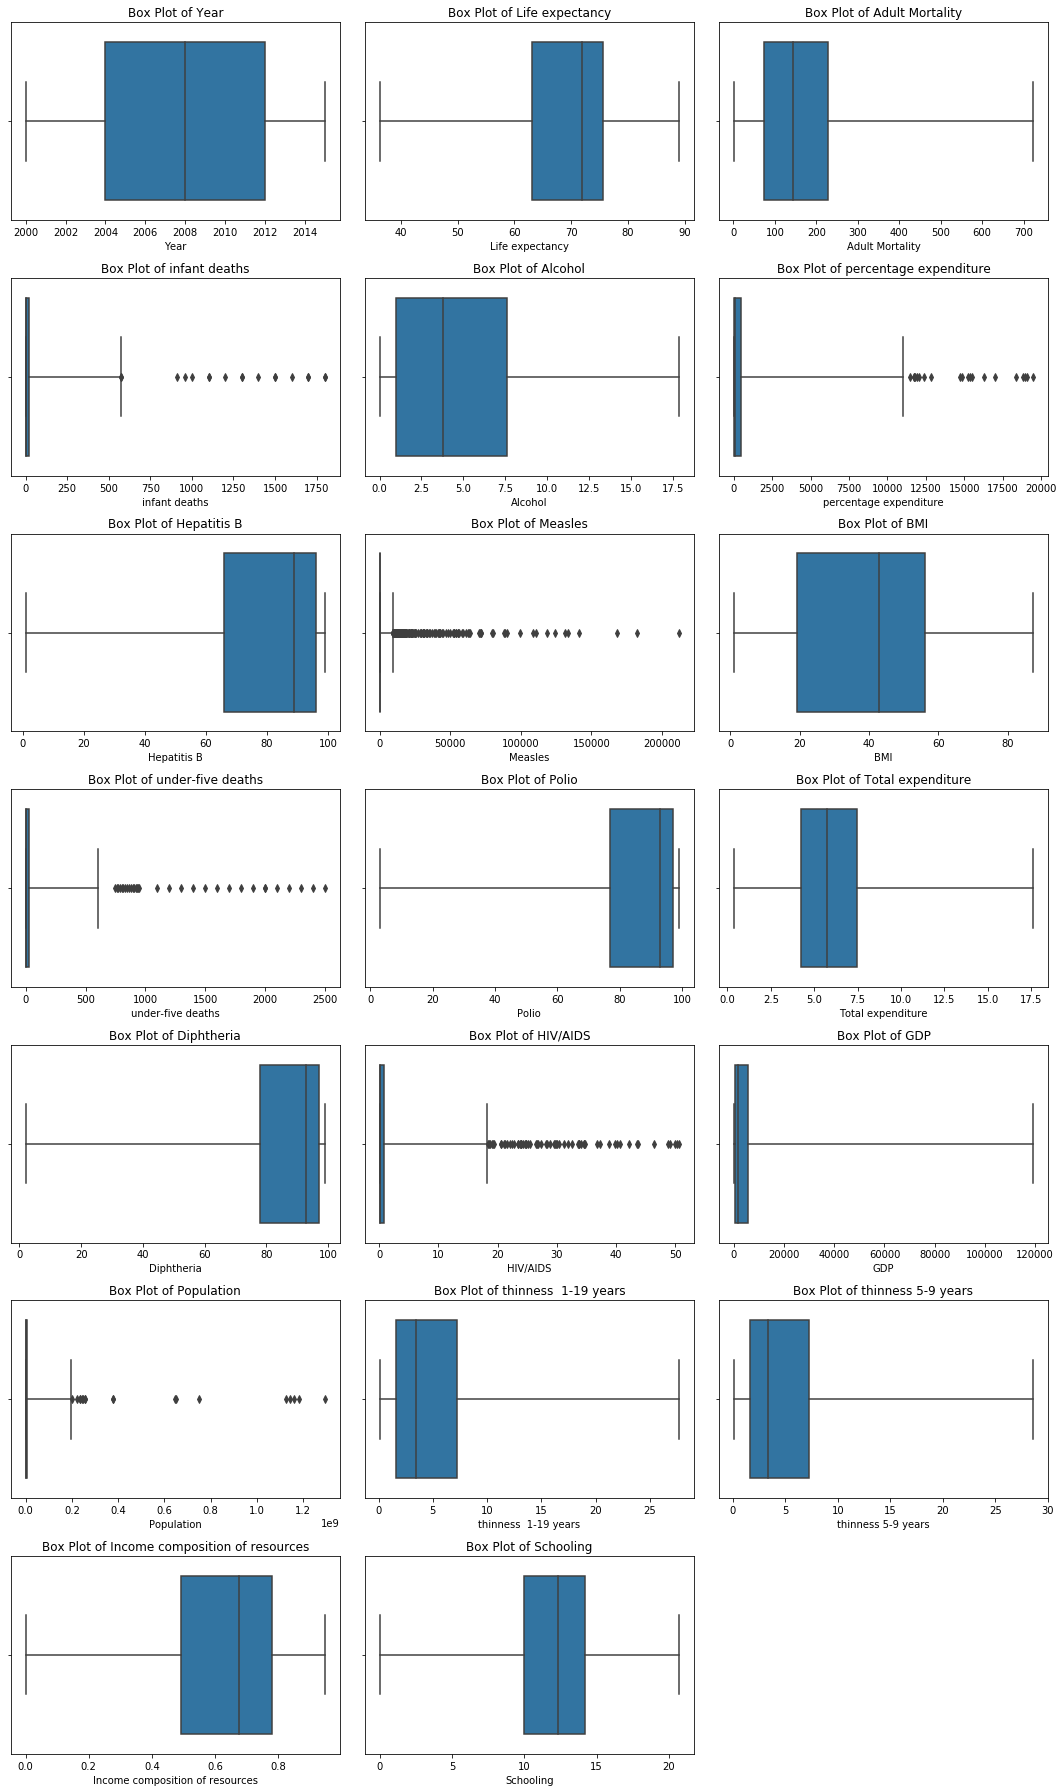

In [11]:
plt.figure(figsize=(15, 25))

# Boxplot for each variable in list
for i, variable in enumerate(variables):
    i += 1
    plt.subplot(7, 3, i)
    sns.boxplot(df[variable], orient='h', whis=25)
    plt.title('Box Plot of {}'.format(variable))
    
plt.tight_layout()
plt.show()

#### Analysis of chart
As shown in the charts above there is ouliers in many variables. Additionally, several of the boxplots showed that several of the variables were positively skewed. As a log transformation can tackle both outliers and positively skewed data, it will be applied to the list below. Note that after the log transformation the outliers have been dealt with see charts below for details.

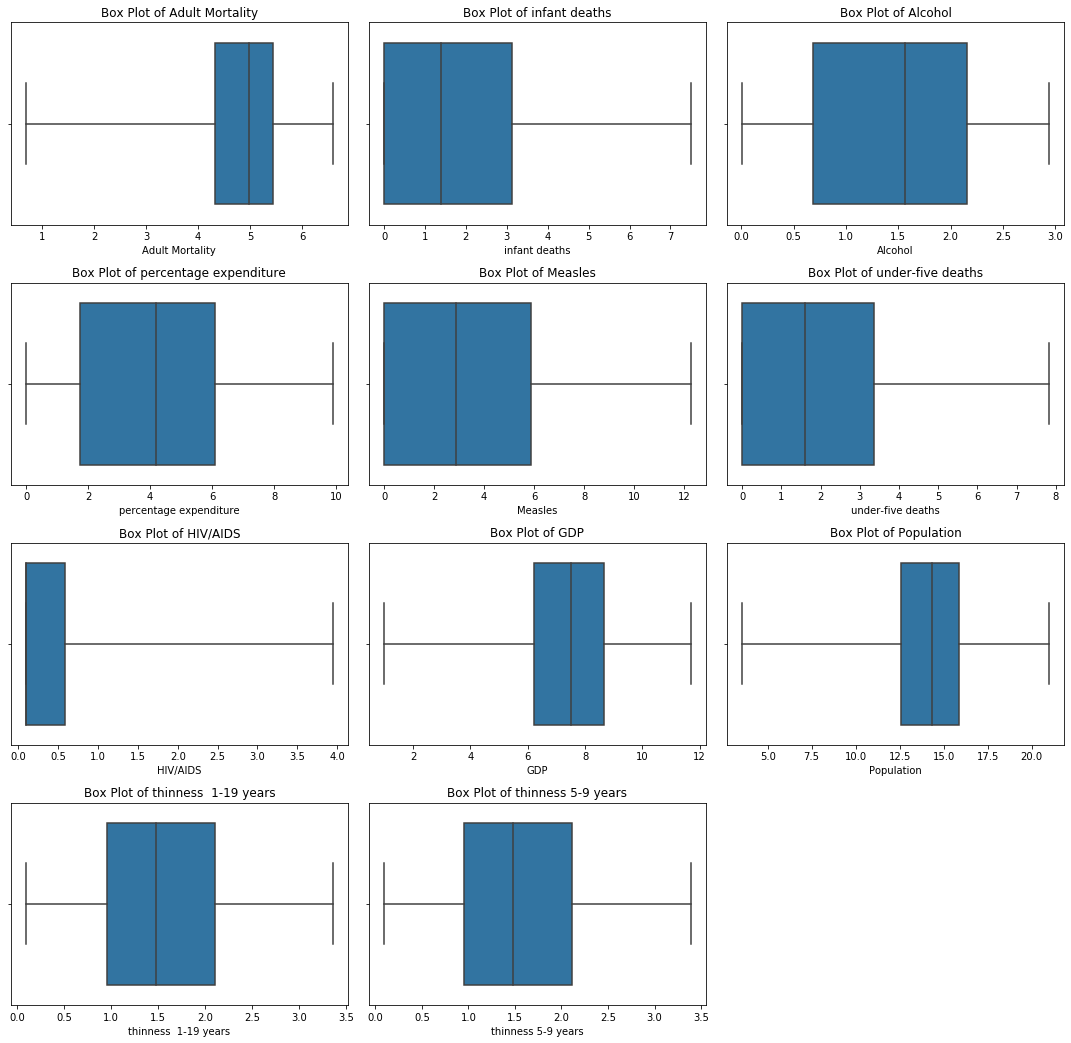

In [12]:
# Create list of identified outliers above and  variables that were 
# positively skewed.
outliers = ['Adult Mortality', 'infant deaths', 'Alcohol',
            'percentage expenditure', 'Measles','under-five deaths', 
            'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 
            'thinness 5-9 years']

df[outliers] = np.log1p(df[outliers])

plt.figure(figsize=(15, 25))

# Generate box plot of the outliers list
for i, variable in enumerate(outliers):
    i += 1
    plt.subplot(7, 3, i)
    sns.boxplot(df[variable], orient='h', whis=25)
    plt.title('Box Plot of {}'.format(variable))
    
plt.tight_layout()
plt.show()

## Exploring the Data
The target of the data exploration is what affects life expectancy. Several questions were asked to understand the data:
1. Which countries have the highest and lowest life expectancy?
2. Which variables affect life expectancy the most?

The data will be groupped by the mean per country. The mean data will used to explore life expectancy.

In [13]:
# Create a new data frame grouped by the average by country
avg_by_country = df.groupby('Country').mean().reset_index()
avg_by_country.head()

,Country,index,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,7.5000,2007.5,58.19375,5.393572,4.365778,0.014249,3.149991,64.5625,7.406980,...,48.3750,8.252500,52.3125,0.095310,5.532272,14.999123,2.749746,2.645656,0.415375,8.21250
1,Albania,23.5000,2007.5,75.15625,3.320583,0.476539,1.760083,4.600141,98.0000,2.120899,...,98.1250,5.945625,98.0625,0.095310,7.010844,11.930886,0.956225,0.987633,0.709875,12.13750
2,Algeria,40.1875,2007.5,73.61875,4.467845,3.058776,0.378981,4.684321,78.7500,4.919045,...,91.7500,4.737188,91.8750,0.095310,7.450024,16.072122,1.958877,1.941972,0.694875,12.71250
3,Angola,56.5000,2007.5,49.01875,5.654494,4.431023,1.829358,3.905407,71.4375,7.206150,...,46.1250,3.886875,47.6875,1.212032,7.094729,15.470218,1.774110,1.867525,0.458375,8.04375
4,Antigua and Barbuda,72.5000,2007.5,75.05625,4.686188,0.000000,2.166849,5.987163,98.1250,0.000000,...,96.9375,4.752188,98.3125,0.117063,8.958451,16.232694,1.486876,1.475665,0.488625,8.84375


### Countries with highest and lowest life expectancy
Lets see which countries have the highest and lowest life expectancies. The top 5 countries are Japan, Sweden, Iceland, Switerland, and France. The bottom 5 countries are Sierra Leone, Niue, Saint Kitts and Nevis, Central African Republic, and Lesotho. 

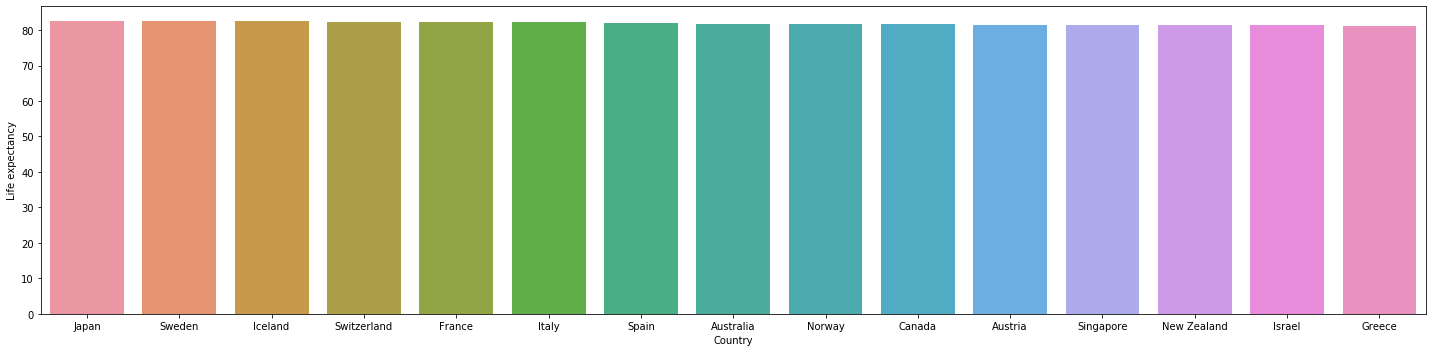

In [14]:
plt.figure(figsize=(20, 5))

# Sort dataframe by largest values
avg_by_country.sort_values(['Life expectancy', 'Country'], 
                           inplace=True, axis=0, ascending=False)

# Generate a bar plot of 15 countries with highest life expectancies
sns.barplot(avg_by_country['Country'].head(15), 
            avg_by_country['Life expectancy'].head(15))

plt.tight_layout()
plt.show()

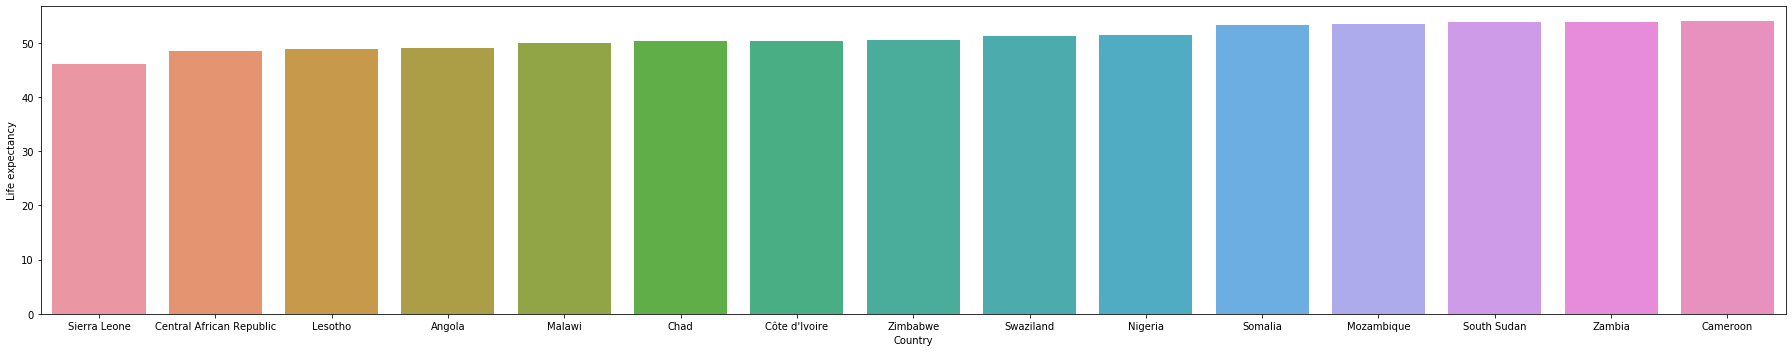

In [15]:
plt.figure(figsize=(25, 5))

# Sort dataframe by smallest values
avg_by_country.sort_values(['Life expectancy', 'Country'],
                           inplace=True, axis=0, ascending=True)

# Generate a bar plot of 15 countries with lowest life expectancies
sns.barplot(avg_by_country['Country'].head(15), 
            avg_by_country['Life expectancy'].head(15))

plt.tight_layout()
plt.show()

### Life Expectancy Correlation
The correlation of the different variables to life expectancy is plotted below. The biggest contributors for low life expectancy is adult mortality and HIV/AIDS; while the biggest contributors for high life expectancy is GDP and a country's income composition of resources. 

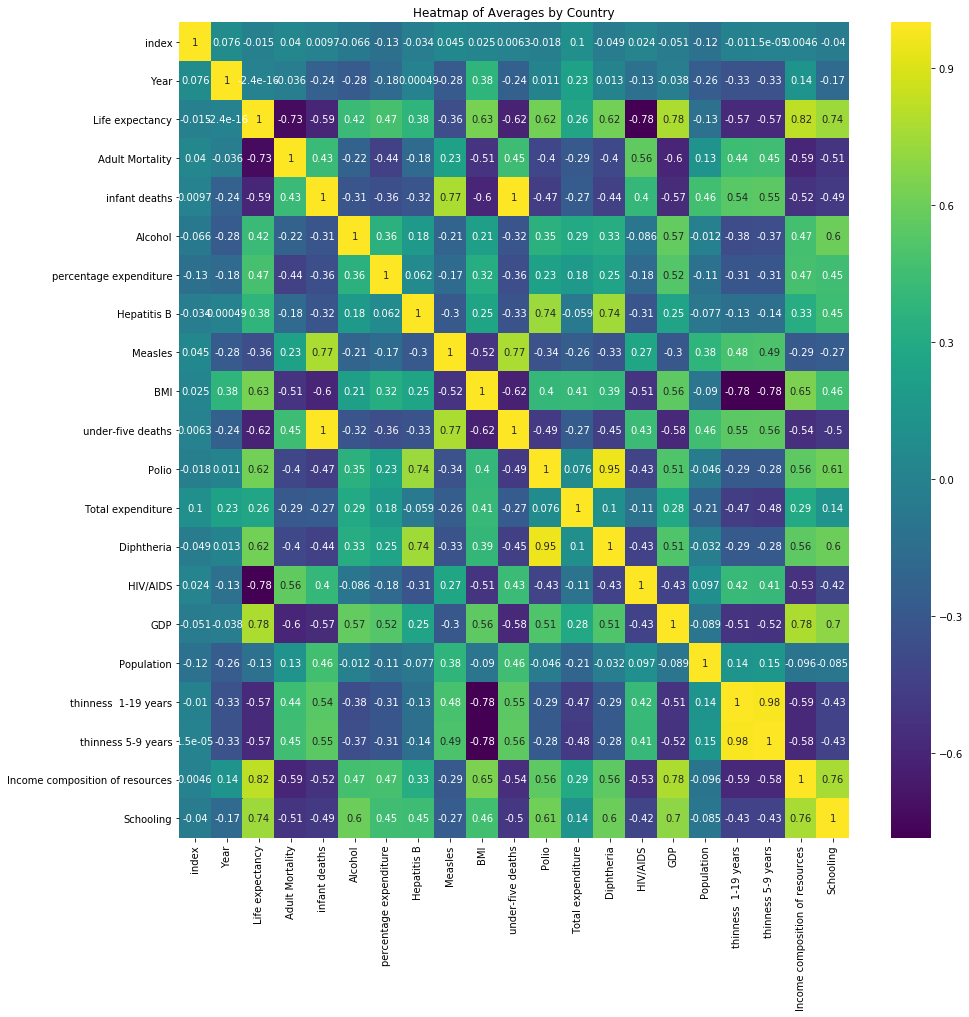

In [16]:
# Generate a heatmap for each variable in avg by country
corr_life = avg_by_country.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_life, annot=True, cmap='viridis')

plt.title('Heatmap of Averages by Country')

plt.show()

In [25]:
# Print out the correlation of each variable 
# against life expectancy, round to 4 decimal places
print(round(corr_life['Life expectancy'], 4))

index                             -0.0149
Year                              -0.0000
Life expectancy                    1.0000
Adult Mortality                   -0.7328
infant deaths                     -0.5897
Alcohol                            0.4247
percentage expenditure             0.4711
Hepatitis B                        0.3759
Measles                           -0.3637
BMI                                0.6331
under-five deaths                 -0.6169
Polio                              0.6209
Total expenditure                  0.2614
Diphtheria                         0.6186
HIV/AIDS                          -0.7779
GDP                                0.7773
Population                        -0.1277
thinness  1-19 years              -0.5695
thinness 5-9 years                -0.5732
Income composition of resources    0.8214
Schooling                          0.7361
Name: Life expectancy, dtype: float64


### Dropping values
Looking at the correlations in the heatmap. Thinness is .98 correlated 1-19 years and 5-9 years. The 'thinness 5-9 years' will be dropped. Likewise Polio and Diptheria is .93 correlated and 'Diptheria' will be dropped. The year will be dropped as this is a useless feature.

In [18]:
# Create list of variables that were highly correlated to another
remove_variables = ['Year', 'Diphtheria', 'thinness 5-9 years']

# remove each item from list
for item in remove_variables: 
    variables.remove(item)

print(variables)

['Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling']


### Scatterplot of Variable vs. Life Expectancy
The correlation above helped narrow down the important features that increase or decrease life expectancy. But what does the correlation of these variables look like? The regplots below help visualize the relationship between the variables and life expectancy. The majority of the variables have a linear relationship with the target variable, but others such as population is more ambiguous. 

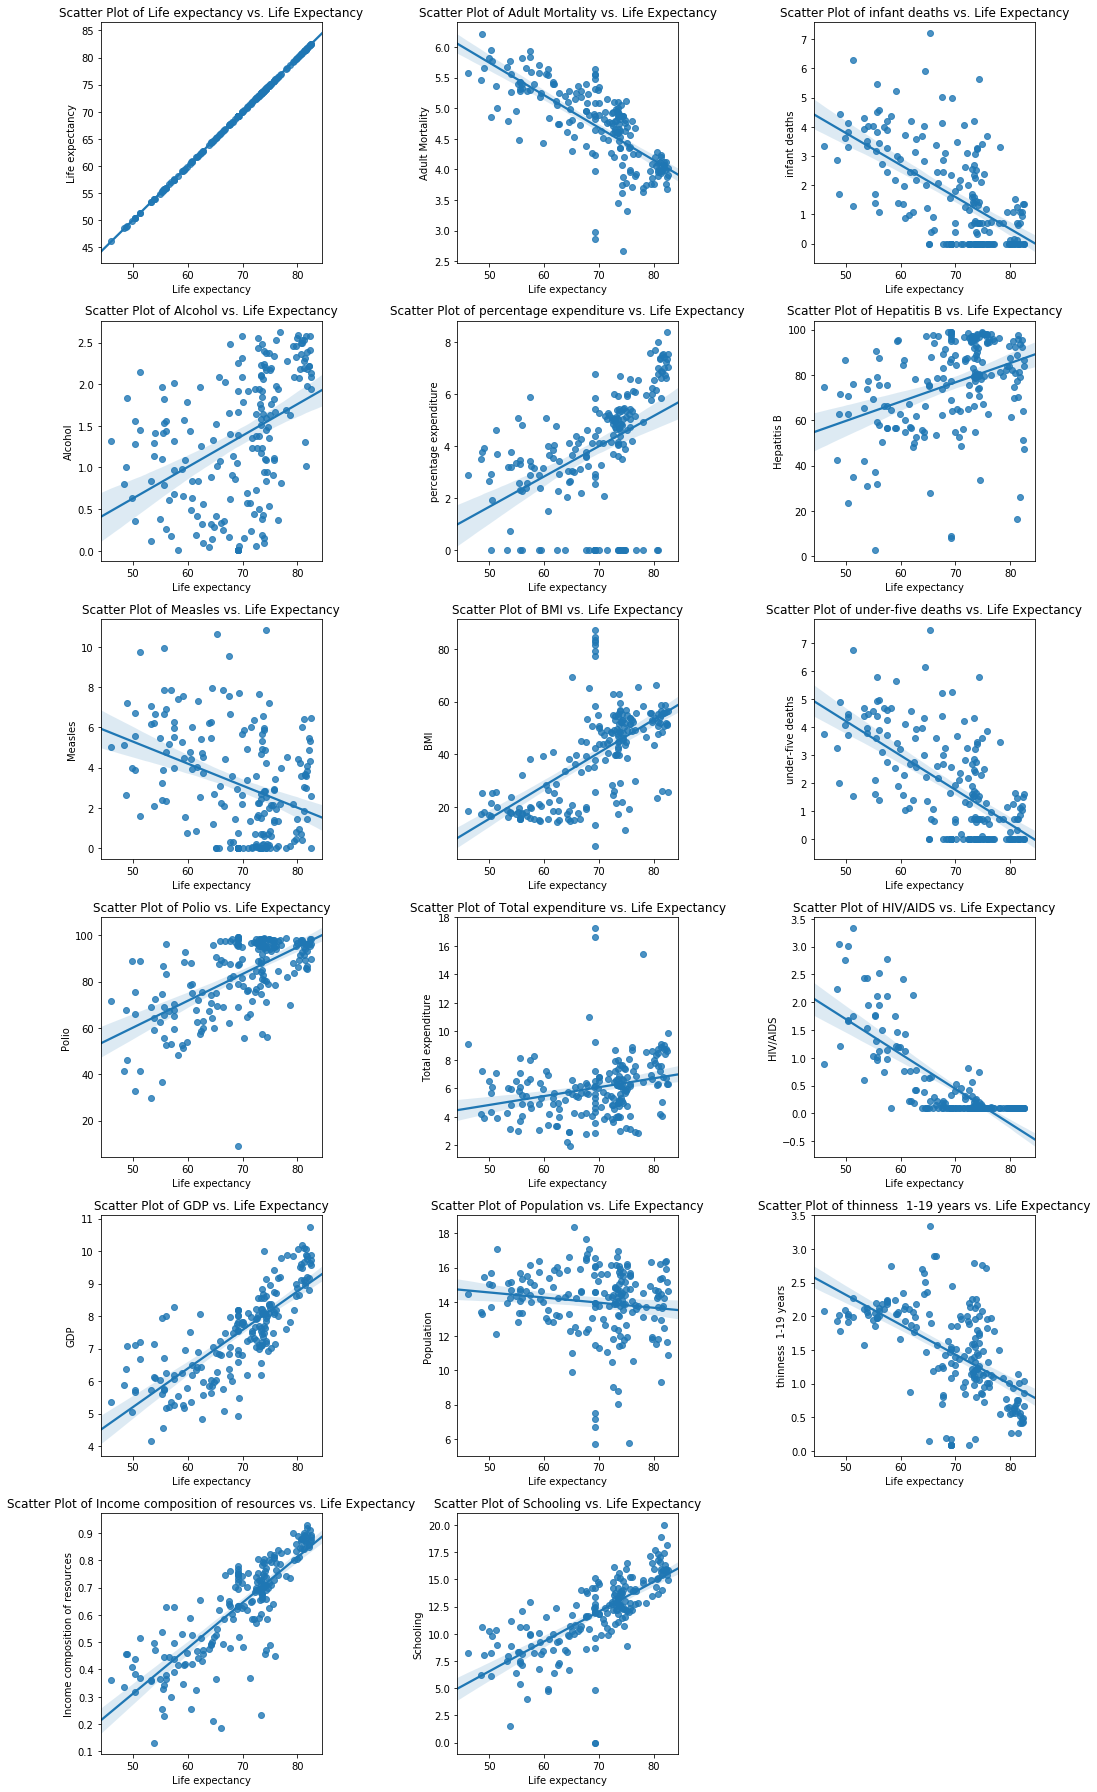

In [19]:
plt.figure(figsize=(15, 25))

# Create scatter plot for each variable vs life expectancy
for i, variable in enumerate(variables):
    i += 1
    plt.subplot(6, 3, i)
    sns.regplot(data=avg_by_country, y=variable, x='Life expectancy')
    plt.title('Scatter Plot of {} vs. Life Expectancy'.format(variable))
    
plt.tight_layout()
plt.show()

## Feature Engineering
PCA will be applied to the variables to reduce it from 17 variables to the ideal number of components. 

In [20]:
# Normalize the data 
X = StandardScaler().fit_transform(avg_by_country[variables])

# Transpose X
Xt = X.T
Cx = np.cov(Xt)

# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[ 0.31955475 -0.2479091  -0.28537306  0.18649546  0.18768251  0.16018444
 -0.21236907  0.27408734 -0.29163403  0.23987399  0.13786713 -0.22604962
  0.29234754 -0.09482517 -0.2545289   0.30099353  0.27669937]
Eigenvalue 1: 7.939854398023811
----------------------------------------
Eigenvector 2: 
[-0.17725574  0.13113669 -0.34128628 -0.17908903 -0.11825516 -0.1348468
 -0.44318186  0.10777017 -0.32835835 -0.19600189  0.20169514  0.10344738
 -0.17572996 -0.45449343 -0.13239628 -0.1985031  -0.26579327]
Eigenvalue 2: 1.8934467238473858
----------------------------------------
Eigenvector 3: 
[-0.00809846  0.15123993 -0.12792536 -0.16414884 -0.25371576  0.57743369
 -0.16853428 -0.13361341 -0.12701705  0.40922114 -0.43263009 -0.10591259
 -0.139678   -0.08510955  0.26117321 -0.09277152  0.06434541]
Eigenvalue 3: 1.5568947551007455
----------------------------------------
Eigenvector 4: 
[-0.17830752  0.27564303 -0.09928508  0.56750369  0.25699285  0.06023808
 -0.06553843 -0.287

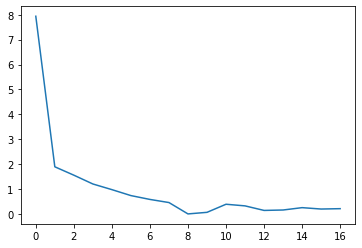

[7.93985440e+00 1.89344672e+00 1.55689476e+00 1.20341194e+00
 9.76501075e-01 7.37263047e-01 5.82852071e-01 4.57630144e-01
 1.11203973e-03 6.46441966e-02 3.89474030e-01 3.23928710e-01
 1.41328489e-01 1.58347949e-01 2.52888594e-01 1.97055537e-01
 2.11907964e-01]


In [21]:
# Print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

In [22]:
# All components above 1 selected for PCA
sklearn_pca = PCA(n_components=4)
pca = sklearn_pca.fit_transform(X)

# Print the percentage for each component
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.46463031 0.11080212 0.09110753 0.07042216]


## Summary and Conclusion
The average life expectancy in the world is 69 years. Japan has the highest life expectancy at 89 years and Sierra Leone has the lowest at 36 years. Based on the correlations the biggest contributors to long life is a nation's GDP, level of education, and income composition of resources. The life expectancy of a nation was shortened if it had a high adult mortality rate, HIV/ AIDS deaths, and childern under 5 deaths. The variables in the dataset were fitted into 4 PCA components. The 4 PCA components above explained 74% of the data variance, which is great for modeling as this reduced the number of features needed in the model. 